In [1]:
import ROOT
import numpy as np
import os 
import copy

Welcome to JupyROOT 6.22/06


In [3]:
def get_tfile_ttree(pion_pair,version):
    if version == "data":
        if pion_pair == [211,111]:
            filesuffix = "Fall2018_RGA_inbending_merged_cuts.root"
        elif pion_pair == [-211,111]:
            filesuffix = "Spring2019_RGA_outbending_merged_cuts.root"
    elif version == "MC":
        if pion_pair == [211,111]:
            filesuffix = "MC_RGA_inbending_merged_cuts.root"
        elif pion_pair == [-211,111]:
            filesuffix = "MC_RGA_outbending_merged_cuts.root"

    pid_str_1 = str(pion_pair[0]).replace("-211","piminus").replace("211","piplus").replace("111","pi0")
    pid_str_2 = str(pion_pair[1]).replace("-211","piminus").replace("211","piplus").replace("111","pi0")

    dihadron_str = f"{pid_str_1}_{pid_str_2}"

    tfile = ROOT.TFile(f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/clas12_dihadrons/projects/pipi0_paper_RGA_only/data/{dihadron_str}/{filesuffix}")
    ttree = tfile.Get("dihadron_cuts")
    return tfile,ttree

In [7]:
pion_pair=[211,111]
tfile_data,tdata = get_tfile_ttree(pion_pair,"data")
tfile_mc,tmc = get_tfile_ttree(pion_pair,"MC")

In [8]:
def canvas_with_ratio(branch_name, xtitle, xmin, xmax, nbins, cut="1",ratio_y_scale=[0.3,1.7]):
    # Parameters
    upper_pad_ratio = 0.65
    lower_pad_ratio = 0.35
    upper_pad_ytitle = ""
    lower_pad_ytitle = "Data/MC"
    lower_pad_yrange = (0.5, 1.5)

    # Create a canvas
    c = ROOT.TCanvas("c", "Histograms", 600, 600)

    # Create the upper pad for histograms
    pad_upper = ROOT.TPad("pad_upper", "pad_upper", 0, lower_pad_ratio, 1, 1)
    pad_upper.SetBottomMargin(0.00)
    pad_upper.SetLeftMargin(0.15)
    pad_upper.Draw()
    pad_upper.cd()

    # Draw the data histogram
    tdata.Draw(f"{branch_name}>>data_hist({nbins}, {xmin}, {xmax})", f"{cut}", "E1", N)
    data_hist = ROOT.gPad.GetPrimitive("data_hist")
    data_hist.SetMarkerColor(ROOT.kRed)
    data_hist.SetLineColor(ROOT.kRed)
    data_hist.SetMarkerStyle(22)
    ROOT.gStyle.SetErrorX(0)
    data_hist.SetTitle("")
    data_hist.GetXaxis().SetTitleSize(0.05)
    data_hist.GetYaxis().SetNdivisions(508)
    data_hist.GetYaxis().SetTitleOffset(0.95)
    data_hist.GetXaxis().SetTitle(xtitle)
    data_hist.GetYaxis().SetTitle(upper_pad_ytitle)
    data_hist.GetYaxis().SetTitleSize(0.045 * (1 / upper_pad_ratio))
    data_hist.GetYaxis().SetLabelSize(0.04 * (1 / upper_pad_ratio))
    
    data_hist.SetStats(False)

    # Draw the MC histogram
    tmc.Draw(f"{branch_name}>>mc_hist({nbins}, {xmin}, {xmax})", f"{cut}", "E1 same", N)
    mc_hist = ROOT.gPad.GetPrimitive("mc_hist")
    mc_hist.SetMarkerColor(ROOT.kBlue)
    mc_hist.SetLineColor(ROOT.kBlue)
    mc_hist.SetMarkerStyle(23)
    mc_hist.SetStats(False)

    # Draw the legend
    legend = ROOT.TLegend(0.5, 0.7, 0.85, 0.85)
    legend.AddEntry(data_hist, "Data", "pe")
    legend.AddEntry(mc_hist, "Monte Carlo", "pe")
    legend.SetBorderSize(1)
    legend.Draw()

    try:
        data_hist.Scale(mc_hist.Integral() / data_hist.Integral())
    except:
        return 0
    ymax = np.amax([data_hist.GetMaximum(), mc_hist.GetMaximum()])
    data_hist.GetYaxis().SetRangeUser(0.0001, ymax * 1.2)

    # Set tick marks on the top and right sides
    ROOT.gPad.SetTickx(1)
    ROOT.gPad.SetTicky(1)

    c.cd()
    # Create the lower pad for ratio
    pad_lower = ROOT.TPad("pad_lower", "pad_lower", 0, 0, 1, lower_pad_ratio)
    pad_lower.SetTopMargin(0.00)
    pad_lower.SetBottomMargin(0.4)
    pad_lower.SetLeftMargin(0.15)
    pad_lower.Draw()
    pad_lower.cd()

    # Calculate the ratio
    ratio_hist = copy.deepcopy(data_hist)
    ratio_hist.Divide(mc_hist)

    # Set the ratio plot attributes
    ratio_hist.SetMarkerStyle(20)
    ratio_hist.SetMarkerColor(ROOT.kBlack)
    ratio_hist.SetLineColor(ROOT.kBlack)
    ratio_hist.GetYaxis().SetTitle(lower_pad_ytitle)
    ratio_hist.GetYaxis().SetNdivisions(503)
    ratio_hist.GetYaxis().SetTitleSize(0.05 * (1 / lower_pad_ratio))
    ratio_hist.GetYaxis().SetLabelSize(0.04 * (1 / lower_pad_ratio))
    ratio_hist.GetXaxis().SetTitleSize(0.06 * (1 / lower_pad_ratio))
    ratio_hist.GetXaxis().SetLabelSize(0.04 * (1 / lower_pad_ratio))
    ratio_hist.GetYaxis().SetRangeUser(ratio_y_scale[0],ratio_y_scale[1])

    # Draw the ratio plot
    ratio_hist.Draw("E1")

    # Draw a dotted horizontal line at y=0
    line = ROOT.TLine(ratio_hist.GetXaxis().GetXmin(), 1, ratio_hist.GetXaxis().GetXmax(), 1)
    line.SetLineStyle(2)
    line.Draw("same")
    
    # Return a deepcopy of the canvas
    return copy.deepcopy(c)

In [9]:
def do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins,ratio_y_scale=[0.3,1.7]):

    # For each cut, create a canvas and draw it in the appropriate pad
    for i in range(n_cuts):
        # Define the cut
        cut = f"{cut_variable} > {cut_bins[i]} && {cut_variable} <= {cut_bins[i+1]}"
        cut_name = f"{cut_variable} #in ({cut_bins[i]:.3f}, {cut_bins[i+1]:.3f})"

        # Create the canvas for this cut
        #c_list.append( canvas_with_ratio(branch_name, xtitle, xmin, xmax, nbins, cut) )
        c = canvas_with_ratio(branch_name, xtitle, xmin, xmax, nbins, cut,ratio_y_scale) 
        cc.append(copy.deepcopy(c))
        
        # Add a title to the pad
        pad_list.append(ROOT.TPaveLabel(0.15, 0.94, 0.9, 0.98, cut_name))
        pad_list[-1].SetFillColor(ROOT.kWhite)



# Zooming in on a Phase Space

In [75]:
import ROOT
import re

def create_tbox(cut_condition):
    # Regular expression pattern to extract variable names and range values
    pattern = r'(\w+)>([-\d.]+)&&\1<([-.\d]+)'
    matches = re.findall(pattern, cut_condition)

    # Extract variable names and range values
    variables = []
    ranges = {}

    for match in matches:
        variable = match[0]
        min_value = float(match[1])
        max_value = float(match[2])

        variables.append(variable)
        ranges[variable] = (min_value, max_value)

    # Set the dimensions based on the parsed ranges
    xmin = ranges[variables[0]][0]
    xmax = ranges[variables[0]][1]
    ymin = ranges[variables[1]][0]
    ymax = ranges[variables[1]][1]

    # Create a TBox object with the specified dimensions
    tbox = ROOT.TBox(xmin, ymin, xmax, ymax)

    # Set the line color
    tbox.SetLineColor(ROOT.kRed)
    tbox.SetLineWidth(2)
    
    # Set the fill color to transparent
    tbox.SetFillColorAlpha(ROOT.kWhite, 0)
    
    # Draw the TBox
    tbox.Draw()

    # Draw axes and labels
    ROOT.gPad.Update()
    ROOT.gPad.RedrawAxis()

    # Return the TBox object
    return tbox


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).


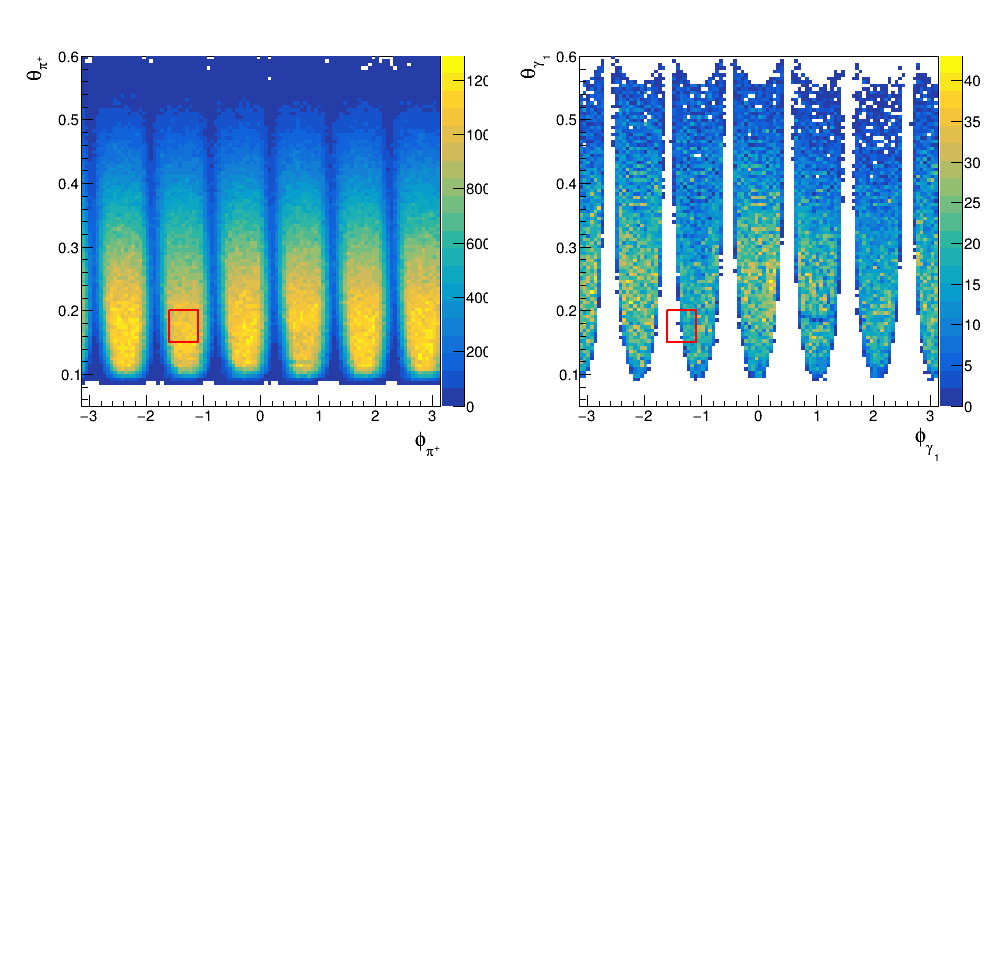

In [79]:
c=ROOT.TCanvas("c","c",1000,1000)
c.Divide(2,2)
c.cd(1)
ROOT.gStyle.SetOptStat(0)
N=int(1e8)

h1=ROOT.TH2F("h1",";#phi_{#pi^{+}};#theta_{#pi^{+}}",100,-3.1415,3.1415,100,0.05,0.6)
h1.GetXaxis().SetTitleSize(0.05)
h1.GetYaxis().SetTitleSize(0.05)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)

cutA = "phi_11>-1.6&&phi_11<-1.1&&th_11>0.15&&th_11<0.2"
tboxA = create_tbox(cutA)

tdata.Draw("th_11:phi_11>>h1","","colz",N)
tboxA.Draw("l same")


c.cd(2)
h2=ROOT.TH2F("h2",";#phi_{#gamma_{1}};#theta_{#gamma_{1}}",100,-3.1415,3.1415,100,0.05,0.6)
h2.GetXaxis().SetTitleSize(0.05)
h2.GetYaxis().SetTitleSize(0.05)
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)

cutB = "phi_21>-1.6&&phi_21<-1.1&&th_21>0.15&&th_21<0.2"
tboxB = create_tbox(cutB)

tdata.Draw("th_21:phi_21>>h2",cutA,"colz",N)
tboxB.Draw("l same")


c.Draw()

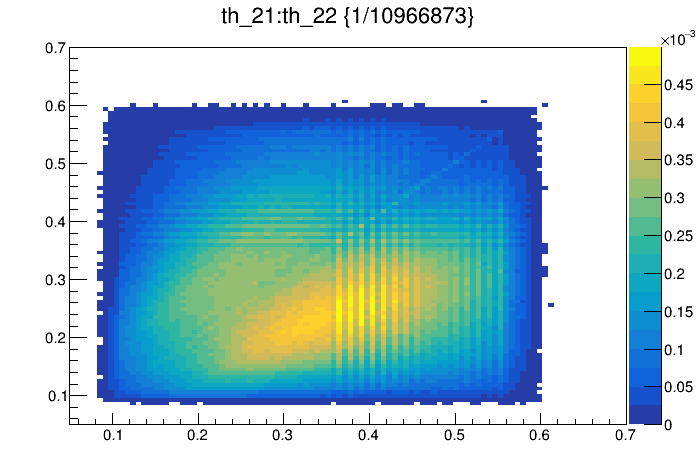

In [106]:
c=ROOT.TCanvas()
tmc.Draw("th_21:th_22>>h(100,0.05,0.7,100,0.05,0.7)",f"1/{tmc.GetEntries()}","colz")
c.Draw()

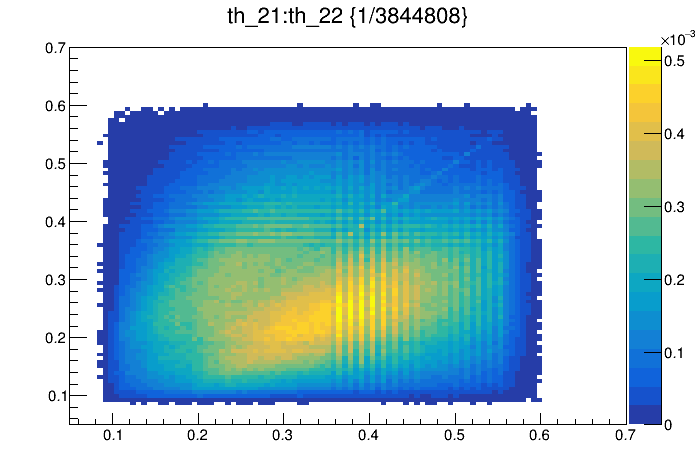

In [107]:
c=ROOT.TCanvas()
tdata.Draw("th_21:th_22>>h(100,0.05,0.7,100,0.05,0.7)",f"1/{tdata.GetEntries()}","colz")
c.Draw()

In [39]:
N=int(1e10)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid_canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


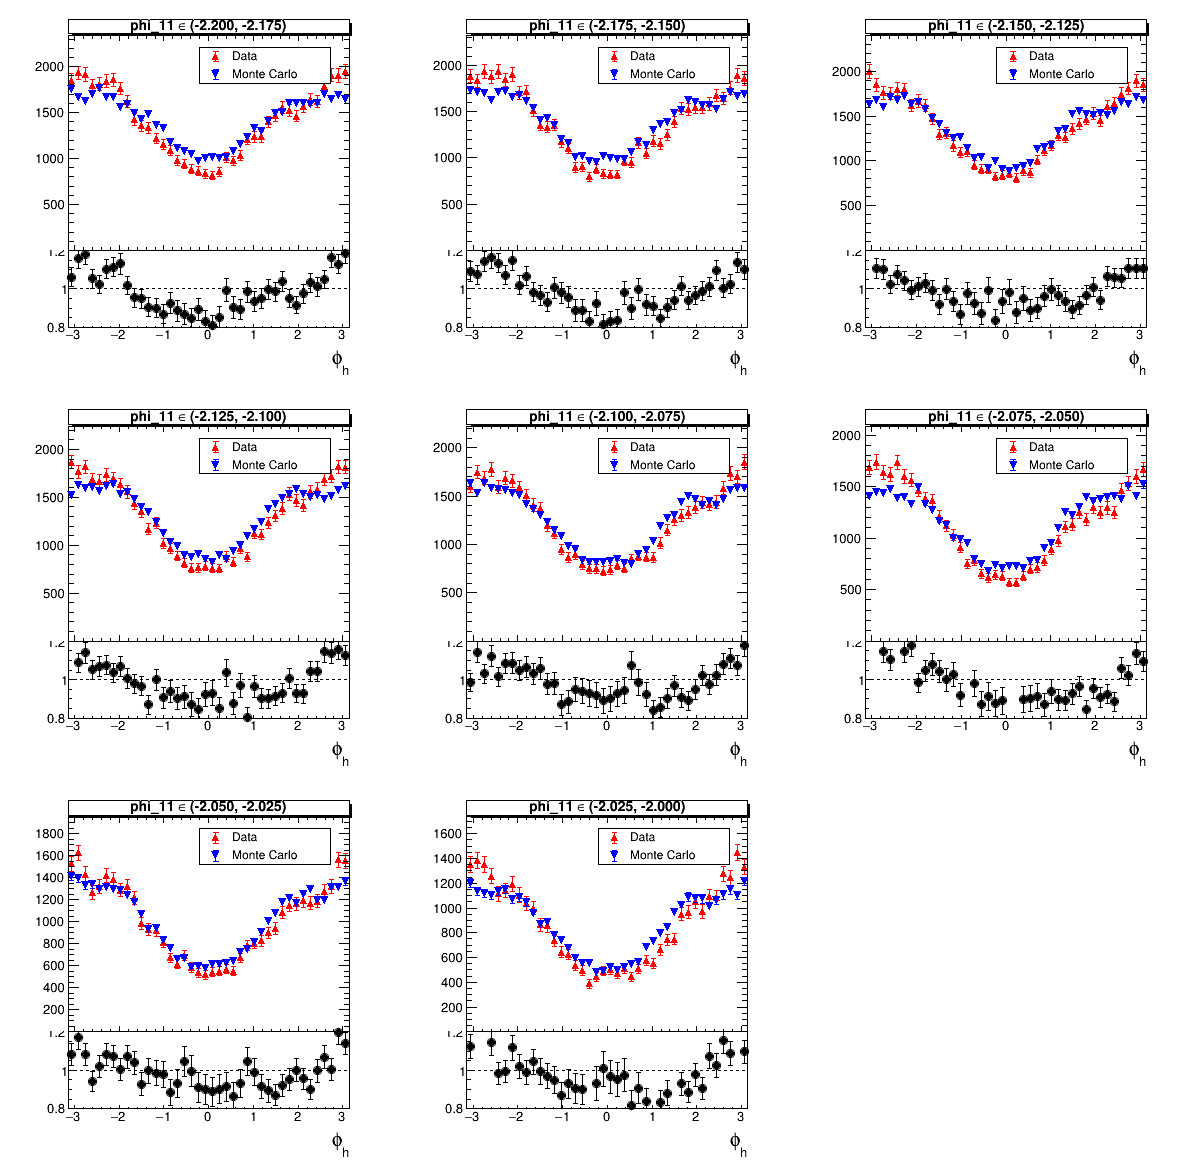

In [40]:
# Define the parameters for your histograms
branch_name = "phi_h"
xtitle = "#phi_{h}"
xmin, xmax = -3.1415,3.1415
nbins = 40

# Ratio y scale
ratio_y_scale = [0.8,1.2]

# Define the cut variable and the bins
cut_variable = "phi_11"
cut_bins = np.linspace(-2.2,-2,9)

# Number of cuts
n_cuts = len(cut_bins) - 1
n_rows = int(np.ceil(n_cuts/3))
# Create the grid canvas
grid_canvas = ROOT.TCanvas("grid_canvas", "Grid of Histograms", 1200, 400*n_rows)
grid_canvas.Divide(3,n_rows)   # 3 columns and n_cuts rows
cc=[]
pad_list=[]
do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins, ratio_y_scale)

for i in range(n_cuts):
    grid_canvas.cd(i+1)
    try:
        cc[i].DrawClonePad()
    except:
        continue # Empty pad
    pad_list[i].Draw()
    
# Draw the grid canvas
grid_canvas.Draw()

# Phi_h binned by the photon thetas

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


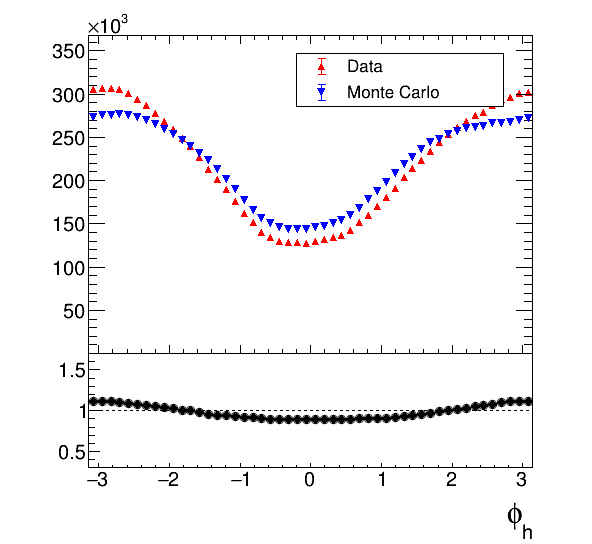

In [97]:
canvas = canvas_with_ratio("phi_h", "#phi_{h}", -3.1415,3.1415, 50)
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


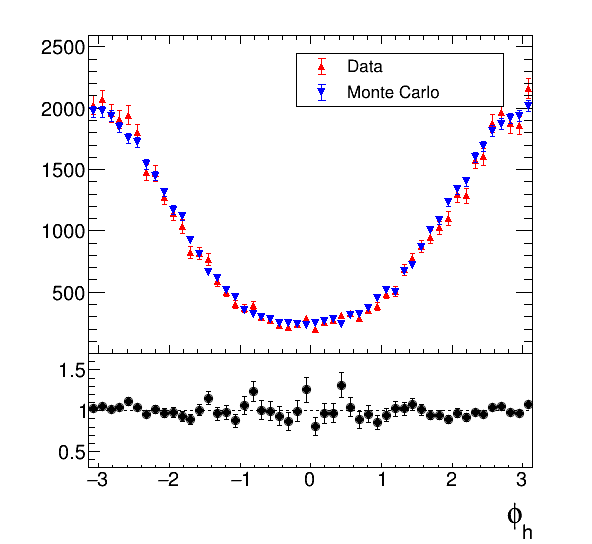

In [99]:
canvas = canvas_with_ratio("phi_h", "#phi_{h}", -3.1415,3.1415, 50,cut="th_21>0.5&&th_22>0.5&&th_21<0.6&&th_22<0.6")
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


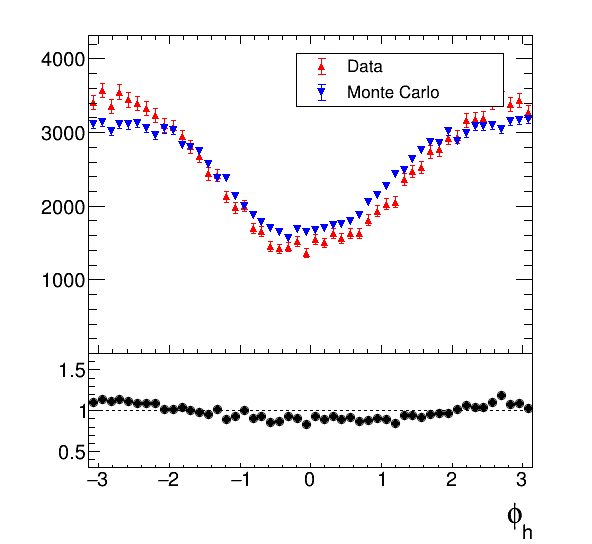

In [100]:
canvas = canvas_with_ratio("phi_h", "#phi_{h}", -3.1415,3.1415, 50,cut="th_21>0.3&&th_22>0.3&&th_21<0.34&&th_22<0.34")
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


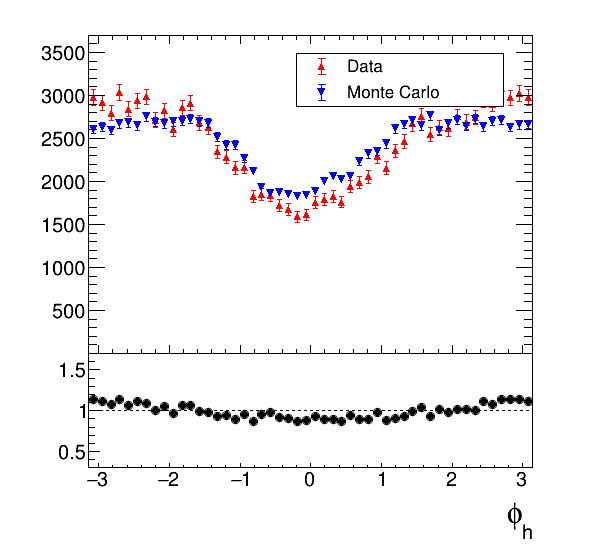

In [101]:
canvas = canvas_with_ratio("phi_h", "#phi_{h}", -3.1415,3.1415, 50,cut="th_21>0.2&&th_22>0.2&&th_21<0.24&&th_22<0.24")
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


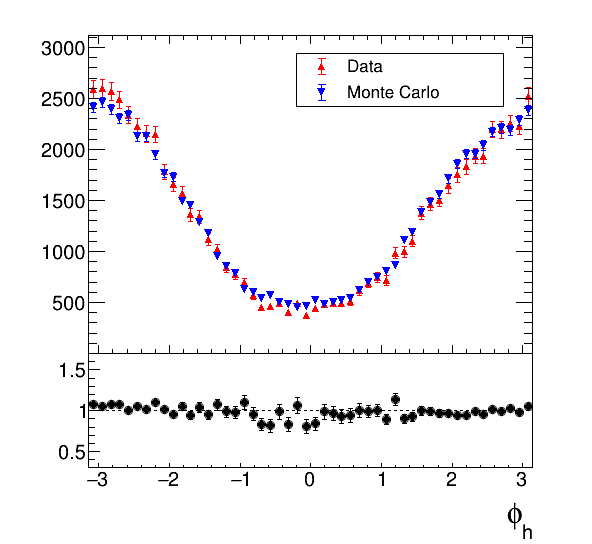

In [102]:
canvas = canvas_with_ratio("phi_h", "#phi_{h}", -3.1415,3.1415, 50,cut="th_21>0.5&&th_22>0.3&&th_21<0.6&&th_22<0.34")
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


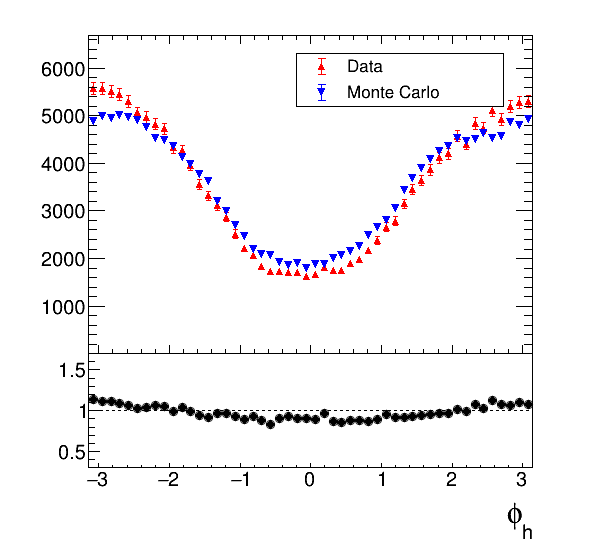

In [103]:
canvas = canvas_with_ratio("phi_h", "#phi_{h}", -3.1415,3.1415, 50,cut="th_21>0.3&&th_22>0.5&&th_21<0.34&&th_22<0.6")
canvas.Draw()

# Binned Plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid_canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Con

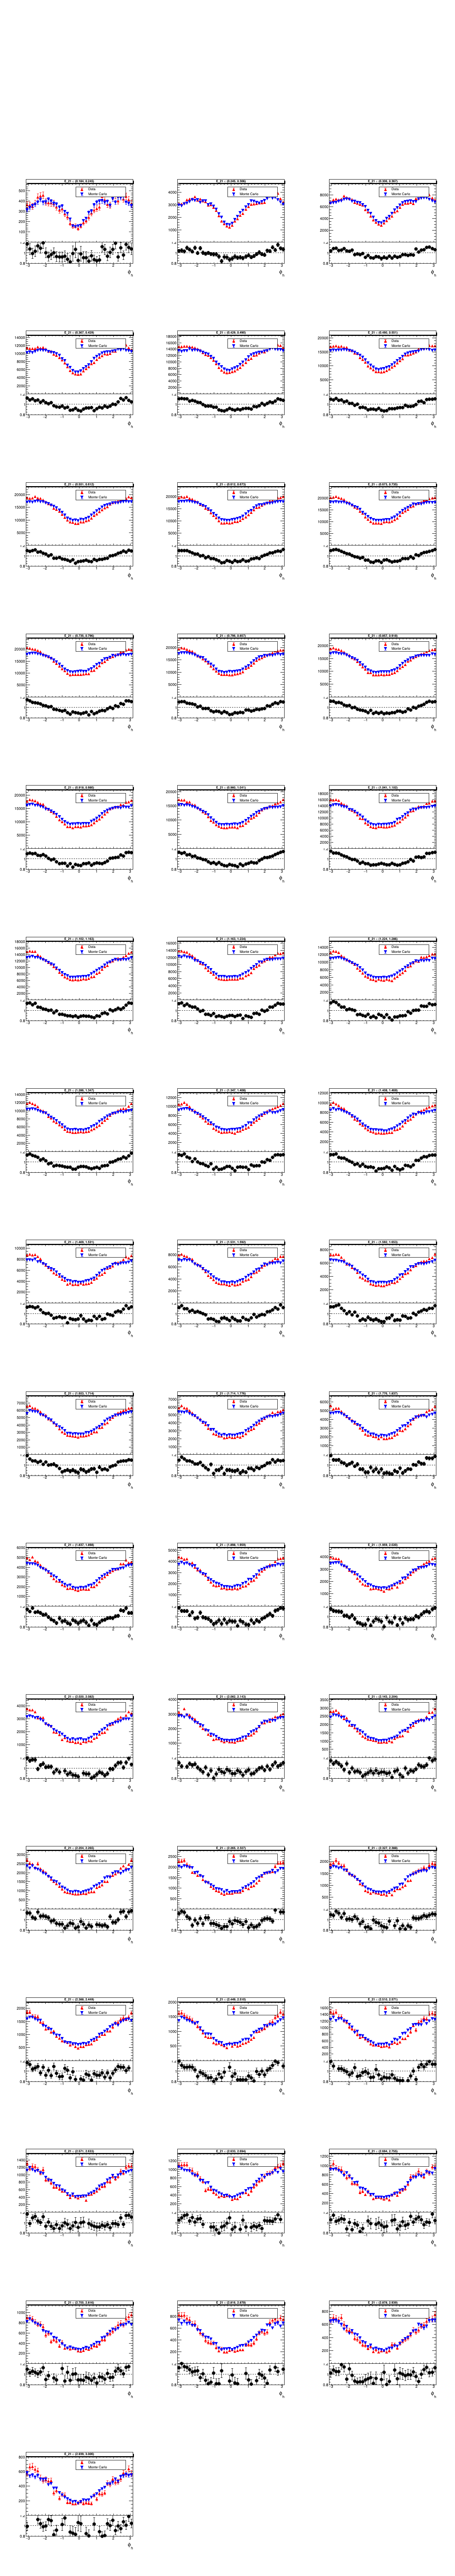

In [81]:
# Define the parameters for your histograms
branch_name = "phi_h"
xtitle = "#phi_{h}"
xmin, xmax = -3.1415,3.1415
nbins = 40

# Ratio y scale
ratio_y_scale = [0.8,1.2]

# Define the cut variable and the bins
cut_variable = "E_21"
cut_bins = np.linspace(0,3,50)

# Number of cuts
n_cuts = len(cut_bins) - 1
n_rows = int(np.ceil(n_cuts/3))
# Create the grid canvas
grid_canvas = ROOT.TCanvas("grid_canvas", "Grid of Histograms", 1200, 400*n_rows)
grid_canvas.Divide(3,n_rows)   # 3 columns and n_cuts rows
cc=[]
pad_list=[]
do_grid_canvas(branch_name, xtitle, xmin, xmax, nbins, cut_variable, cut_bins, ratio_y_scale)

for i in range(n_cuts):
    grid_canvas.cd(i+1)
    try:
        cc[i].DrawClonePad()
    except:
        continue # Empty pad
    pad_list[i].Draw()
    
# Draw the grid canvas
grid_canvas.Draw()